In [1]:
import os
from tqdm import tqdm
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from python_speech_features import mfcc

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Flatten, MaxPool2D, LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

Using TensorFlow backend.


### Plotting data of clean directory

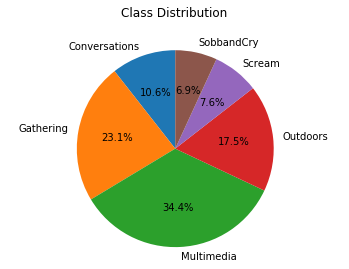

In [3]:
df=pd.read_csv('./audio2.csv')
df.set_index('audiofile', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('DataClean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()


### data preparation in form of metrices to feed in Neural Network



In [11]:
# for taking samples from our audio dataset by dividing length of the total data by 10th of the second chunks|
n_samples= 2 * int(df['length'].sum()/0.1)
print(n_samples)

37956


In [6]:
prob_dist=class_dist/class_dist.sum()
print(prob_dist)

label
Conversations    0.105802
Gathering        0.230511
Multimedia       0.343704
Outdoors         0.175186
Scream           0.076133
SobbandCry       0.068663
Name: length, dtype: float64


In [7]:
choices= np.random.choice(class_dist.index,p=prob_dist)
print(classes)

['Conversations', 'Gathering', 'Multimedia', 'Outdoors', 'Scream', 'SobbandCry']


In [8]:
#  preparation of X and y metrices to be feeded in our model 

def build_rand_feat():
    X=[]
    y=[]
    _min,_max= float('inf'), -float('inf')
    
    for _ in tqdm(range(n_samples)):
        
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('DataClean/'+file)
        label=df.at[file,'label']
        rand_index=np.random.randint(0,wav.shape[0]-config.step)
        
        sample=wav[rand_index:rand_index+config.step]
        X_sample=mfcc(sample, rate, nfilt=config.nfilt, numcep=config.nfeat, nfft=config.nfft).T
        
        _min=min(np.amin(X_sample),_min)
        _max=max(np.amax(X_sample),_max)
        

        X.append(X_sample if config.mode=='conv' else X_sample.T)
        y.append(classes.index(label))
        
    X, y = np.array(X), np.array(y)
        
    X= (X - _min)/ (_max - _min)
        
#         print(X.shape)
    if config.mode=='conv' :
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode=='time':
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
            
    y=to_categorical(y,num_classes=10)
        
    return X,y


In [9]:
class Config:
    
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode=mode
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.nfft=nfft
        self.rate=rate
        self.step= int(rate/10)

###  CNN

In [18]:
config = Config(mode='conv')

In [17]:
def  get_conv_model():
    
    model=Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1), padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1), padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1), padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    return model
    
    

In [13]:
def get_recurrent_model():
    
#     shape of data for RNN is (n,time,feat)
    
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

In [19]:
if config.mode == 'conv':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2],1)
    model=get_conv_model()
    
elif config.mode == 'time':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2])
    model=get_recurrent_model()

100%|██████████| 37956/37956 [01:26<00:00, 436.59it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
__________

In [20]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)

In [21]:
model.fit(x,y,epochs=5,batch_size=32,shuffle=True,class_weight=class_weight)

Epoch 1/5
37956/37956 [==============================] - 74s 2ms/step - loss: 0.5026 - acc: 0.8192
Epoch 2/5
37956/37956 [==============================] - 71s 2ms/step - loss: 0.2991 - acc: 0.8953
Epoch 3/5
37956/37956 [==============================] - 78s 2ms/step - loss: 0.2442 - acc: 0.9156
Epoch 4/5
37956/37956 [==============================] - 82s 2ms/step - loss: 0.2094 - acc: 0.9285
Epoch 5/5
37956/37956 [==============================] - 82s 2ms/step - loss: 0.1796 - acc: 0.9377


### RNN

In [14]:
config = Config(mode='time')
if config.mode == 'conv':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2],1)
    model=get_conv_model()
    
elif config.mode == 'time':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2])
    model=get_recurrent_model()

100%|██████████| 37956/37956 [01:18<00:00, 486.34it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 16)             528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 8)              136       
__________

In [15]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)

In [16]:
model.fit(x,y,epochs=5,batch_size=32,shuffle=True,class_weight=class_weight)

Epoch 1/5
37956/37956 [==============================] - 29s 762us/step - loss: 0.8897 - acc: 0.6739
Epoch 2/5
37956/37956 [==============================] - 27s 702us/step - loss: 0.5572 - acc: 0.7988
Epoch 3/5
37956/37956 [==============================] - 27s 708us/step - loss: 0.4674 - acc: 0.8357
Epoch 4/5
37956/37956 [==============================] - 25s 669us/step - loss: 0.4109 - acc: 0.8575
Epoch 5/5
37956/37956 [==============================] - 27s 711us/step - loss: 0.3756 - acc: 0.8692
